# Adult Income Classification

## Problem Statement

By unravelling the intricate interplay of demographic and socio-economic attributes, our goal is to develop a model that not only discerns the financial trajectories of diverse populations but also sheds light on the intricate factors shaping economic prosperity. This problem falls under the broader category of binary classification, where the goal is to classify instances into one of two categories – in this case, whether an individual's income is above or below $50,000. The dataset under consideration contains various features, including race, gender, age, country, hours worked, education, occupation, and, crucially, the binary response variable of income.

## Significance of the Problem

Predicting income levels has practical uses outside of academia. Understanding the elements that contribute to an individual's income level is critical for policymakers, economists, and social scientists. It enables the discovery of patterns and discrepancies, which aids in developing targeted initiatives and policies aimed at reducing income inequality.

The capacity to anticipate revenue effectively based on demographic characteristics has consequences for personal finance, marketing initiatives, and resource allocation. Businesses, for example, can modify their marketing efforts based on their target audience's expected income tiers.

## Dataset and Features

The dataset at hand is highly pertinent to the situation, as it includes factors such as race, gender, age, nation, hours worked, education, occupation, and income. Each feature gives vital information that may contribute to the model's prediction power. As an example:

1. Race and gender: These characteristics may throw light on potential biases and discrepancies in income distribution, assisting in the identification and resolution of discrimination issues.
2. Age and education: These two criteria are frequently associated with professional advancement and salary levels. Analyzing their influence can reveal information about the relationship between education, experience, and financial success.
3. Country: Economic conditions and societal norms differ by country, and this feature helps the model to represent the geographical context impacting income levels. Analyzing their influence can reveal information about the relationship between education, experience, and financial success.
4. Working Hours and Occupation: These characteristics are strongly related to employment status and job type, both of which have a major impact on income.
A well-constructed classifier can provide useful insights into the dynamics of income determination by studying and comprehending the correlations between various traits, contributing to a more informed understanding of socioeconomic issues influencing financial well-being.


## Parsing and Normalizing Input Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

In [2]:
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


def create_education(data, normalized_database_filename):
    with create_connection(normalized_database_filename, True) as conn:
        create_education_sql = """
        CREATE TABLE [Education] (
            [EducationLevel] INTEGER NOT NULL PRIMARY KEY,
            [Education] TEXT NOT NULL
        );
        """
        create_table(conn, create_education_sql, drop_table_name="Education")
        
        education_records =  list(set([(line[4], line[3]) for line in data]))
        education_records = sorted(education_records)

        conn.executemany("INSERT INTO Education(EducationLevel, Education) VALUES(?, ?)", education_records)
        conn.execute("COMMIT")

    return None

def create_occupation(data, normalized_database_filename):
    with create_connection(normalized_database_filename) as conn:
        create_occupation_sql = """
        CREATE TABLE [Occupation] (
            [OccupationID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
            [Occupation] TEXT NOT NULL
        );
        """
        create_table(conn, create_occupation_sql, drop_table_name="Occupation")
        
        occupation_records =  list(set([(line[6], ) for line in data]))
        occupation_records = sorted(occupation_records)

        conn.executemany("INSERT INTO Occupation(Occupation) VALUES(?)", occupation_records)
        conn.execute("COMMIT")

    return None

def create_country(data, normalized_database_filename):
    with create_connection(normalized_database_filename) as conn:
        create_country_sql = """
        CREATE TABLE [Country] (
            [CountryID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
            [Country] TEXT NOT NULL
        );
        """
        create_table(conn, create_country_sql, drop_table_name="country")
        
        country_records =  list(set([(line[-2], ) for line in data]))
        country_records = sorted(country_records)

        conn.executemany("INSERT INTO Country(Country) VALUES(?)", country_records)
        conn.execute("COMMIT")

    return None

def create_person_details(data, normalized_database_filename):
    with create_connection(normalized_database_filename) as conn:
        create_person_details_sql = """
        CREATE TABLE [PersonDetails] (
            [PersonID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
            [Age] INTEGER NOT NULL,
            [WorkClass] TEXT NOT NULL,
            [FunctionalWeight] INTEGER NOT NULL,
            [EducationLevel] INTEGER NOT NULL,
            [MaritalStatus] TEXT NOT NULL,
            [OccupationID] INTEGER NOT NULL,
            [Relationship] TEXT NOT NULL,
            [Race] TEXT NOT NULL,
            [Gender] TEXT NOT NULL,
            [CapitalGain] INTEGER NOT NULL,
            [CapitalLoss] INTEGER NOT NULL,
            [HoursPerWeek] INTEGER NOT NULL,
            [CountryID] INTEGER NOT NULL,
            [Income] TEXT NOT NULL,
            FOREIGN KEY (EducationLevel) REFERENCES Education(EducationLevel),
            FOREIGN KEY (OccupationID) REFERENCES Occupation(OccupationID),
            FOREIGN KEY (CountryID) REFERENCES Country(CountryID)
        );
        """
        create_table(conn, create_person_details_sql, drop_table_name="PersonDetails")
        
        occupation_records = dict(execute_sql_statement("SELECT Occupation, OccupationID FROM Occupation", conn))
        country_records = dict(execute_sql_statement("SELECT Country, CountryID FROM Country", conn))

        person_details_records =  list([
            (
                line[0], line[1], line[2], line[4], line[5], 
                occupation_records[line[6]], 
                line[7], line[8], line[9], line[10], line[11], line[12], 
                country_records[line[13]], line[14]
            ) 
            for line in data])

        conn.executemany("INSERT INTO PersonDetails(Age, WorkClass, FunctionalWeight, EducationLevel, MaritalStatus, OccupationID, Relationship, Race, Gender, CapitalGain, CapitalLoss, HoursPerWeek, CountryID, Income) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);", person_details_records)
        conn.execute("COMMIT")

    return None

data_filename = "adult.csv"
normalized_database_filename = "adults_income.db"

with open(data_filename) as file:
    lines =[line.strip() for line in file.readlines()[1:]]
    data = list(map(lambda line: line if "?" not in line.split(",") else None, lines))

data = [line.split(",") for line in data if line != None]

create_education(data, normalized_database_filename)
create_occupation(data, normalized_database_filename)
create_country(data, normalized_database_filename)
create_person_details(data, normalized_database_filename)

with create_connection(normalized_database_filename) as conn:
    df = pd.read_sql_query("SELECT * FROM PersonDetails", conn)


## Reading from Normalized Database

In [3]:
df_eda = pd.read_sql_query("""
SELECT
    Age
    , WorkClass
    , FunctionalWeight
    , Education
    , MaritalStatus
    , Occupation
    , Relationship
    , Race
    , Gender
    , CapitalGain
    , CapitalLoss
    , HoursPerWeek
    , Country
    , CASE WHEN Income = "<=50K" THEN 0 ELSE 1 END AS Income
FROM
    PersonDetails JOIN Education
        ON PersonDetails.EducationLevel = Education.EducationLevel
    JOIN Occupation
        ON PersonDetails.OccupationID = Occupation.OccupationID
    JOIN Country
        ON PersonDetails.CountryID = Country.CountryID
""", conn)

# Explanatory Data Analysis

In [4]:
print(df_eda.head())

   Age  WorkClass  FunctionalWeight     Education       MaritalStatus  \
0   25    Private            226802          11th       Never-married   
1   38    Private             89814       HS-grad  Married-civ-spouse   
2   28  Local-gov            336951    Assoc-acdm  Married-civ-spouse   
3   44    Private            160323  Some-college  Married-civ-spouse   
4   34    Private            198693          10th       Never-married   

          Occupation   Relationship   Race Gender  CapitalGain  CapitalLoss  \
0  Machine-op-inspct      Own-child  Black   Male            0            0   
1    Farming-fishing        Husband  White   Male            0            0   
2    Protective-serv        Husband  White   Male            0            0   
3  Machine-op-inspct        Husband  Black   Male         7688            0   
4      Other-service  Not-in-family  White   Male            0            0   

   HoursPerWeek        Country  Income  
0            40  United-States       0  
1   

In [5]:
print(df_eda['Income'].value_counts())

0    34014
1    11208
Name: Income, dtype: int64


The Given dataset has around 34000 people with income levels less than 50K and 11000 people with Income more than 50K

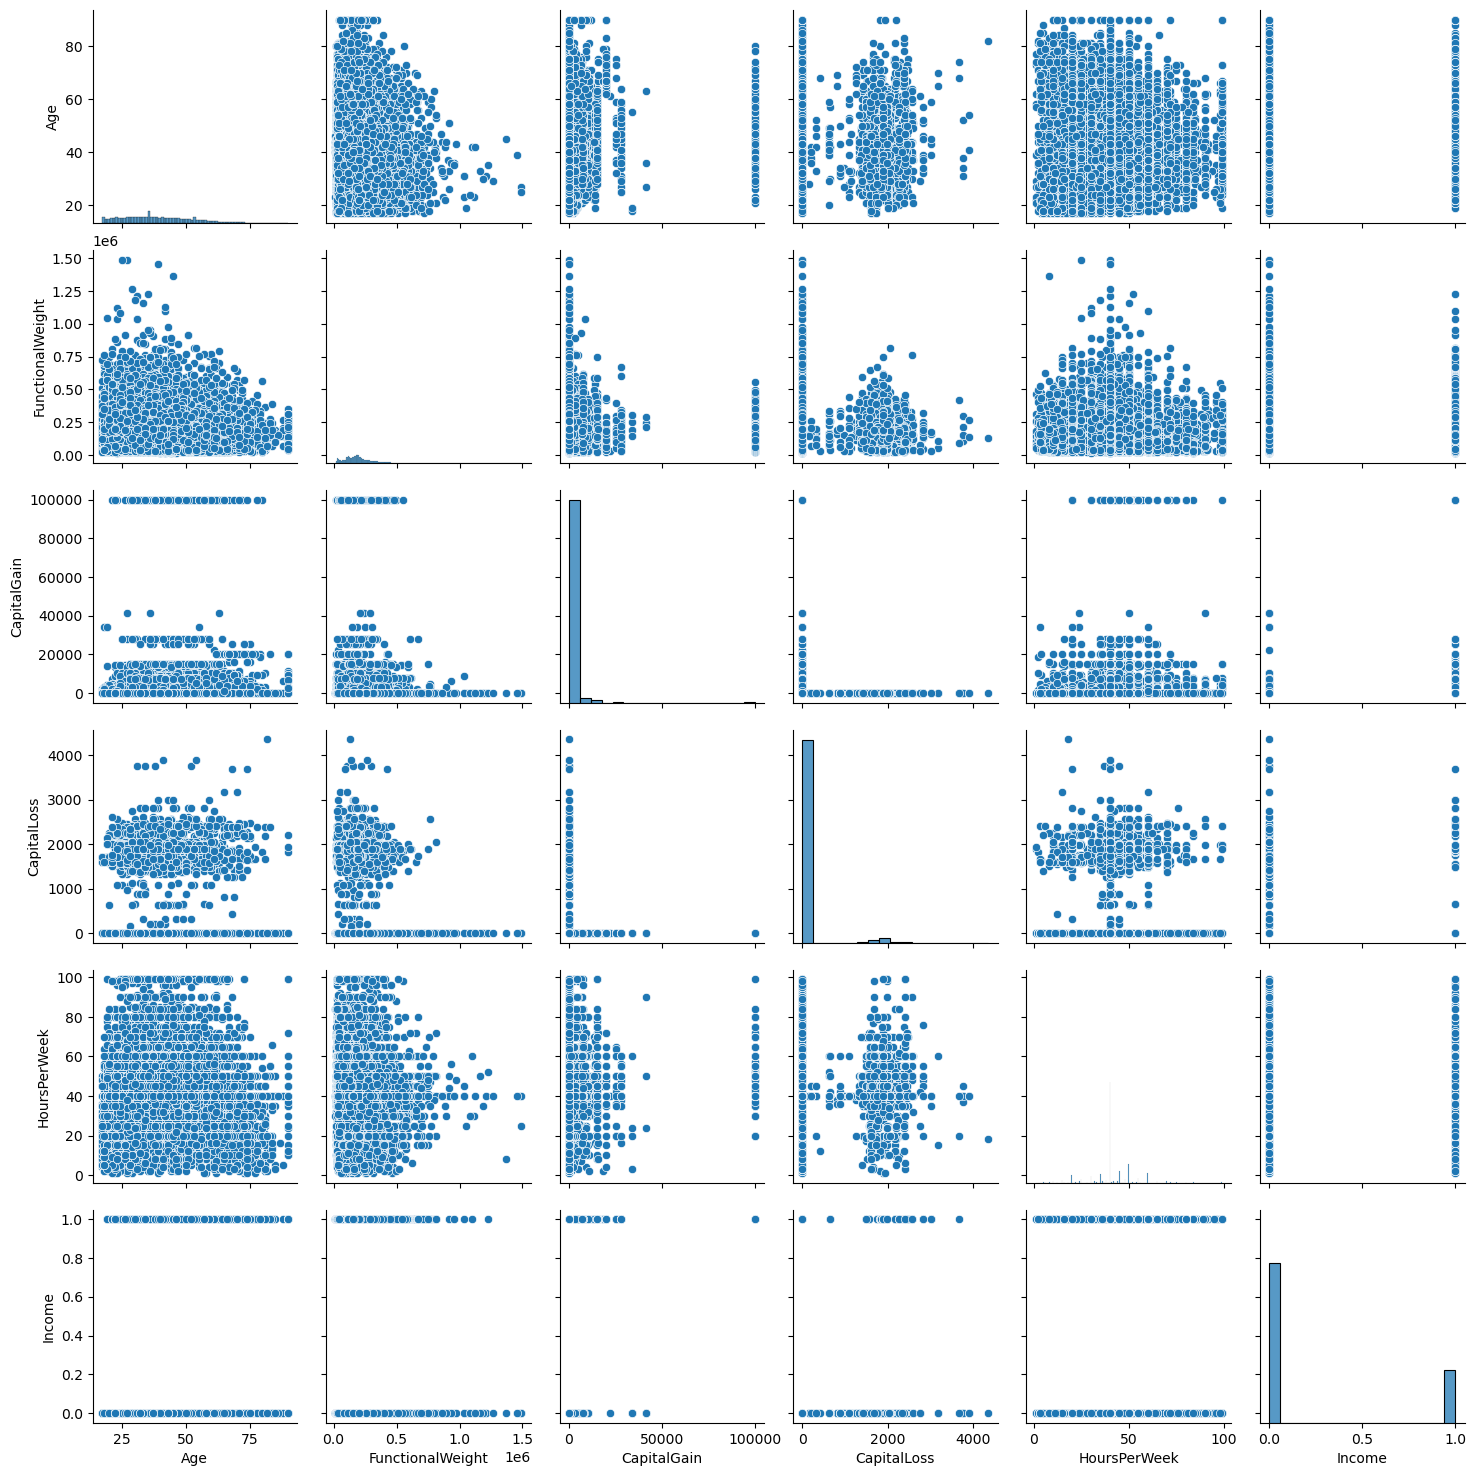

In [6]:
sns.pairplot(df_eda)
plt.show()

# Univariate Analysis

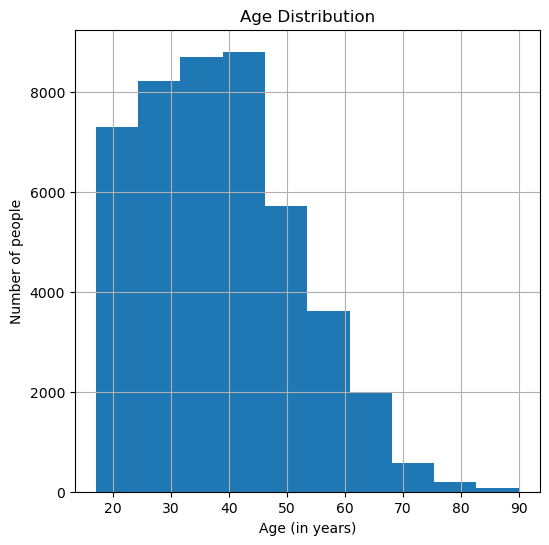

In [7]:
df_eda['Age'].hist(figsize = (6,6))
pyplot.title('Age Distribution')
pyplot.xlabel('Age (in years)')
pyplot.ylabel('Number of people')
plt.show()


The data is skewed left with more people having age less than 50 years and fewer people have age greater than 50.

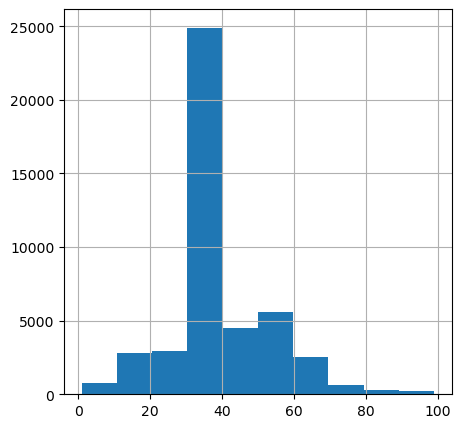

In [8]:
df['HoursPerWeek'].hist(figsize=(5,5))

plt.show()

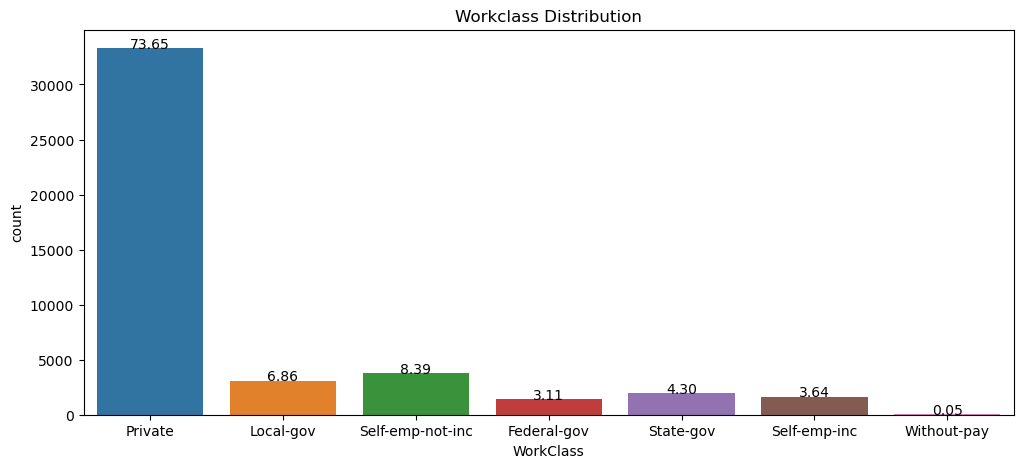

In [9]:
plt.figure(figsize=(12,5))

total = float(len(df_eda['Income']))

a = sns.countplot(x='WorkClass',data=df_eda)

for f in a.patches:
    height = f.get_height()
    a.text(f.get_x() + f.get_width()/2., height+3, '{:1.2f}'.format((height/total)*100),ha="center")
pyplot.title('Workclass Distribution')
plt.show()


### Education Distribution

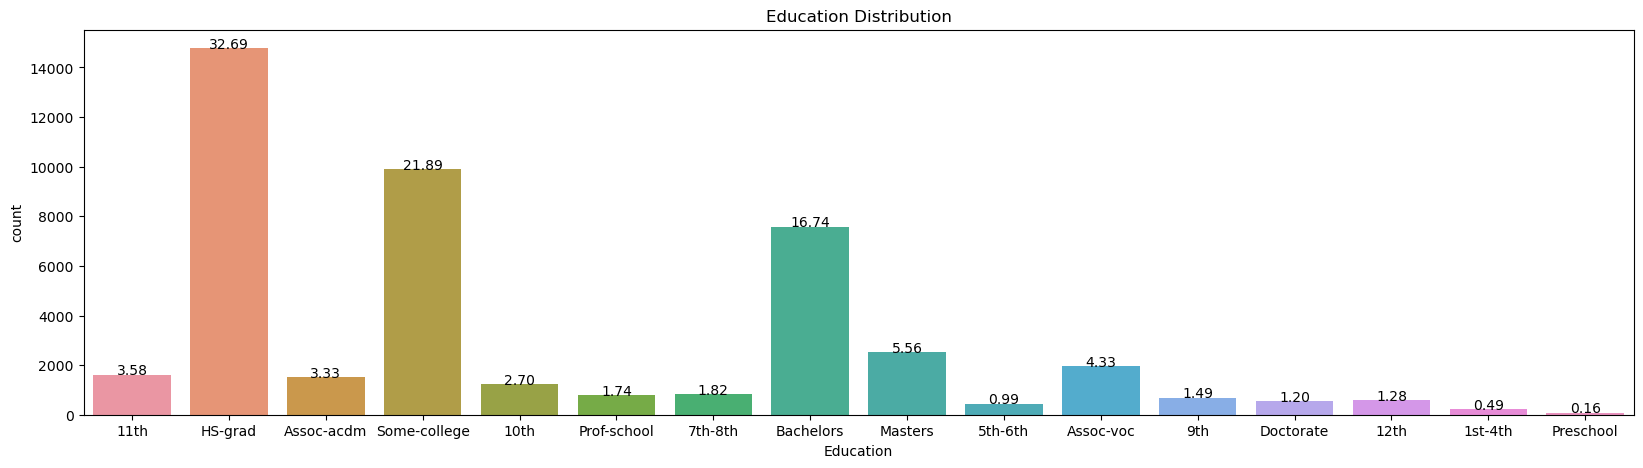

In [10]:
plt.figure(figsize=(20,5))

a= float(len(['Income']))

a= sns.countplot(x='Education',data=df_eda)
for s in a.patches:
    height = s.get_height()
    a.text(s.get_x()+s.get_width()/2.,height+3,'{:1.2f}'.format((height/total)*100),ha='center')
pyplot.title('Education Distribution')
plt.show()

## Race Distribution

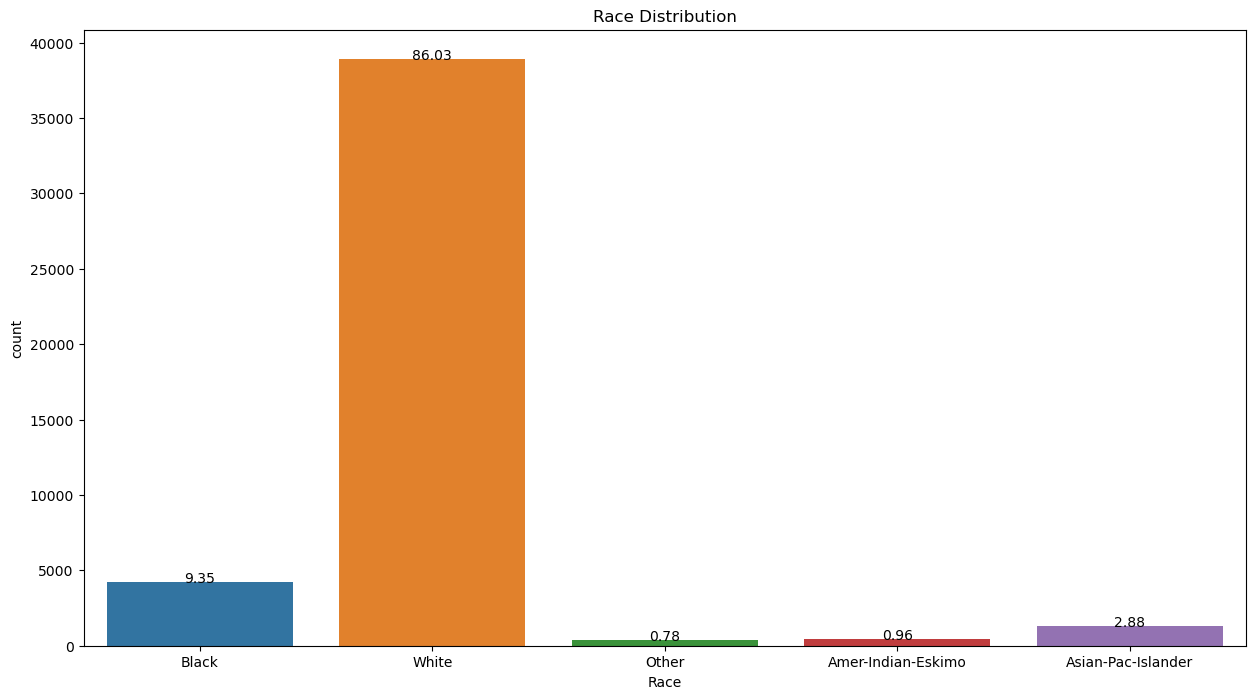

In [11]:
plt.figure(figsize=(15,8))
total = float(len(df_eda) )

ax = sns.countplot(x="Race", data=df_eda)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
pyplot.title('Race Distribution')
pyplot.xlabel('Race')
plt.show()


## Income Distribution

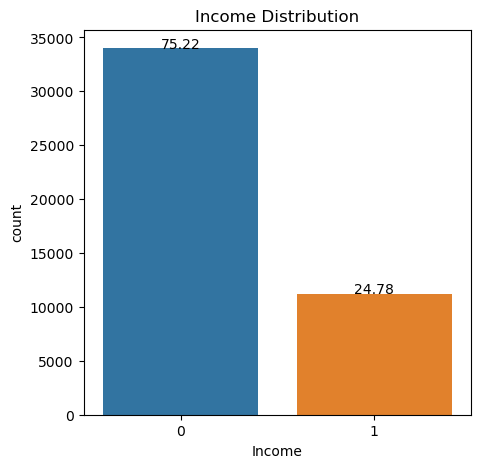

In [12]:
plt.figure(figsize=(5,5))
total = float(len(df_eda) )

ax = sns.countplot(x="Income", data=df_eda)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
pyplot.title('Income Distribution')
plt.show()

## Bivariate Analysis 

### Age and it's Relationship with Income 

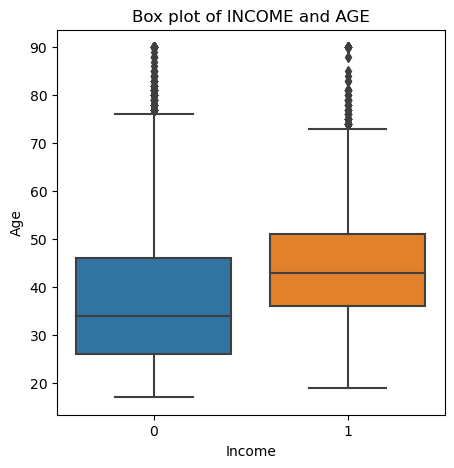

In [13]:
fig = plt.figure(figsize=(5,5))
sns.boxplot(x='Income',y='Age',data=df_eda).set_title('Box plot of INCOME and AGE')
plt.show()

### Workclass-Income Relationship

Text(0.5, 1.0, 'workclass vs count')

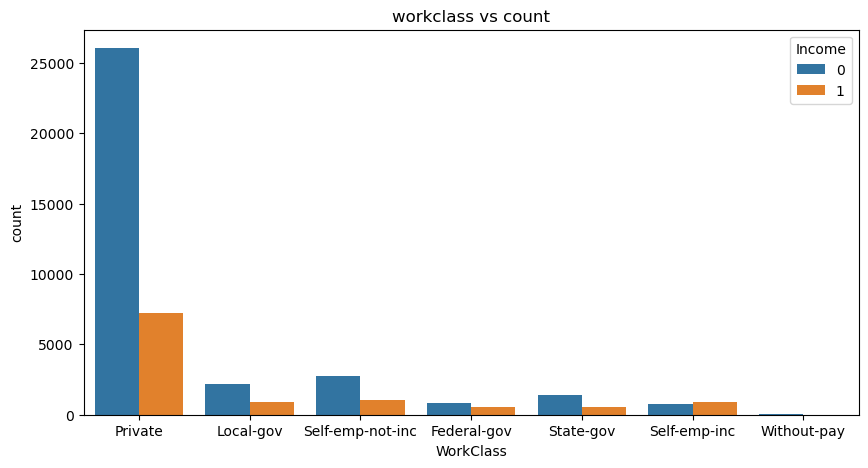

In [14]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='WorkClass',hue ='Income',data=df_eda).set_title("workclass vs count")


80% of the People working in the private sector has salary less than 50k.

### Family-Income Relationship

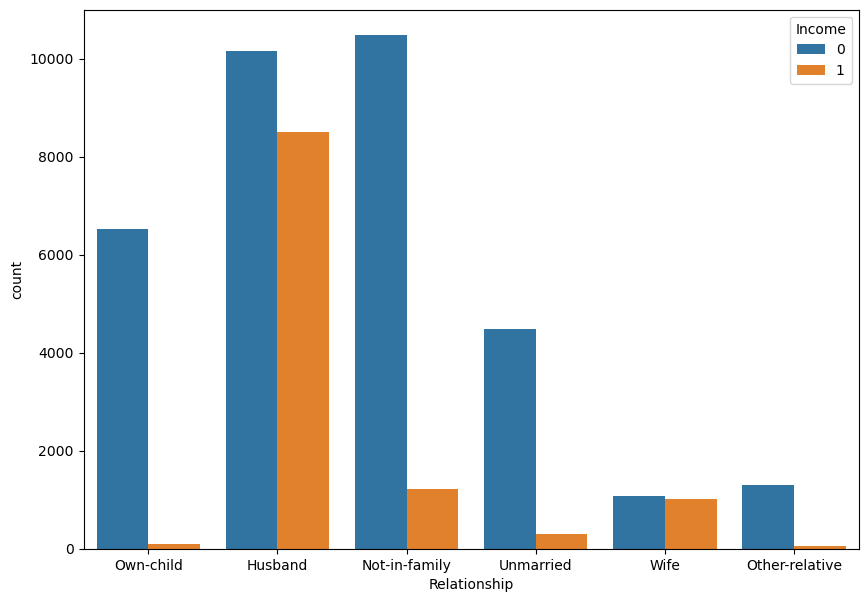

In [15]:
plt.figure(figsize=(10,7))
sns.countplot(x="Relationship", hue="Income",
            data=df_eda)
plt.show()

### Race-Income Relationship

<Figure size 2000x500 with 0 Axes>

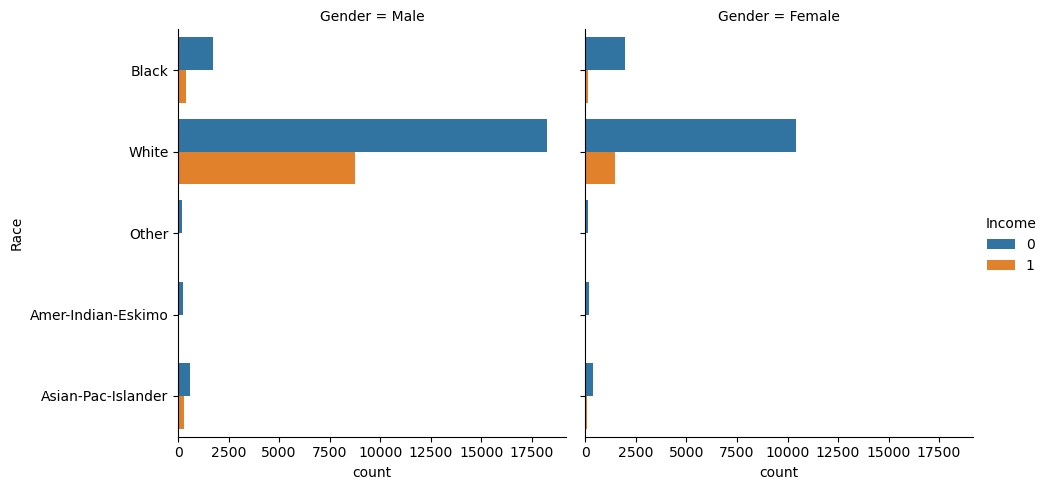

In [16]:
plt.figure(figsize=(20,5))
sns.catplot(y="Race", hue="Income", kind="count",col="Gender", data=df_eda)
plt.show()

###  Workclass and their Respective Incomes

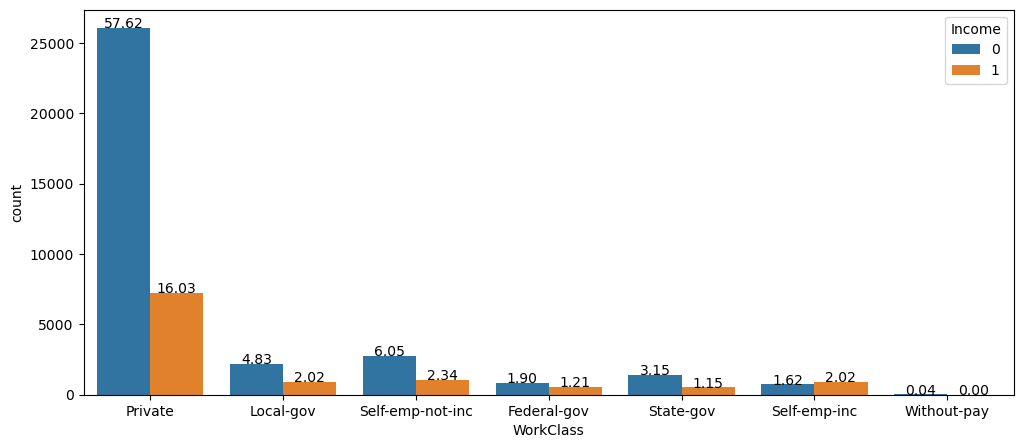

In [17]:
plt.figure(figsize=(12,5))
total = float(len(df_eda["Income"]) )

ax = sns.countplot(x="WorkClass", hue="Income", data=df_eda)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
plt.show()

### Education Level and their Income

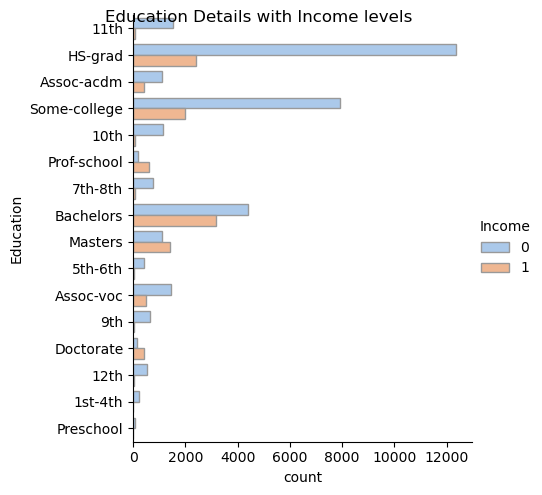

In [18]:
rel=sns.catplot(y="Education", hue="Income", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_eda)
rel.fig.suptitle('Education Details with Income levels')
plt.show()

### MaritalStatus and their Incomes  

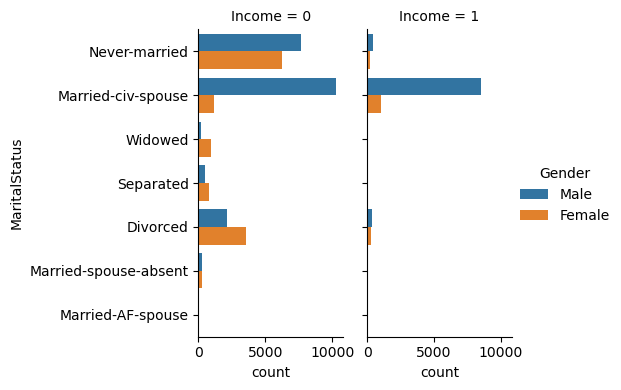

In [19]:
ct = sns.catplot(y='MaritalStatus',hue='Gender',col='Income',data=df_eda,kind='count',
                height=4,aspect=.7)
plt.show()

### Correlation Heat Map

C:\Users\ajayv\AppData\Local\Temp\ipykernel_3820\4132382837.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_eda.corr())


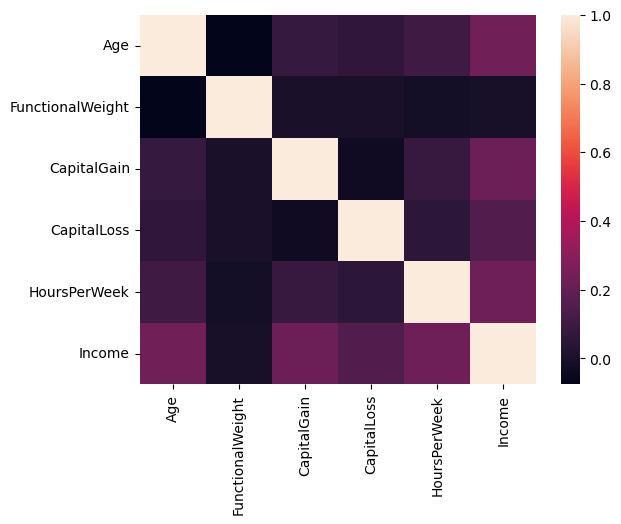

In [20]:
sns.heatmap(df_eda.corr())
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()

for col_name, col_type in zip(df.columns, df.dtypes):
    if col_type.name == "object":
        df[col_name] = label_encoder.fit_transform(df[col_name])

[x_train, x_test, y_train, y_test] = train_test_split(df.loc[:, df.columns != "Income"], df["Income"], test_size=0.3, random_state=50)

model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

predictions = model.predict(x_test)

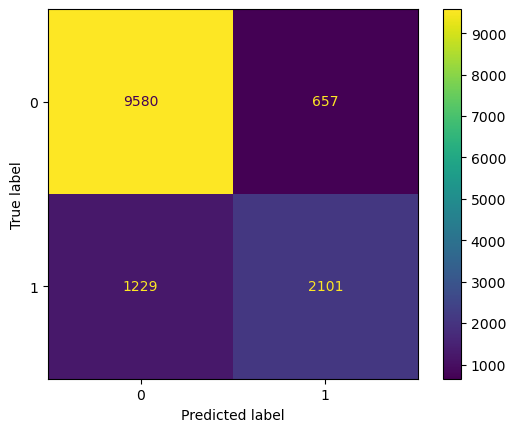

Accuracy Score - Random Forest:  0.8609862165548758
Precision Score - Random Forest:  0.76178390137781
Recall Score - Random Forest:  0.6309309309309309


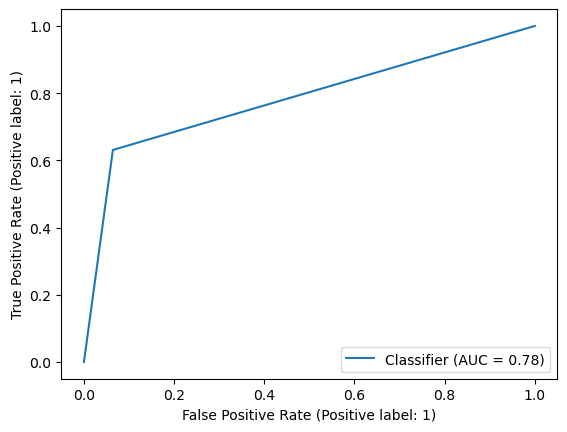

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, accuracy_score, precision_score, recall_score

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

display.plot()
plt.show()

display = RocCurveDisplay.from_predictions(
    y_test,
    predictions
)

print("Accuracy Score - Random Forest: ", accuracy_score(y_test, predictions))
print("Precision Score - Random Forest: ", precision_score(y_test, predictions))
print("Recall Score - Random Forest: ", recall_score(y_test, predictions))

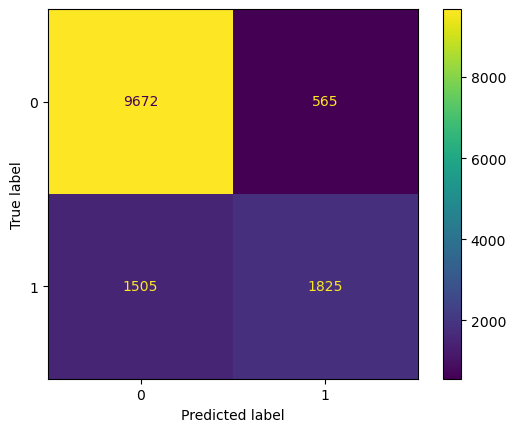

Accuracy Score - Decision Tree:  0.8474238962187661
Precision Score - Decision Tree:  0.7635983263598326
Recall Score - Decision Tree:  0.5480480480480481


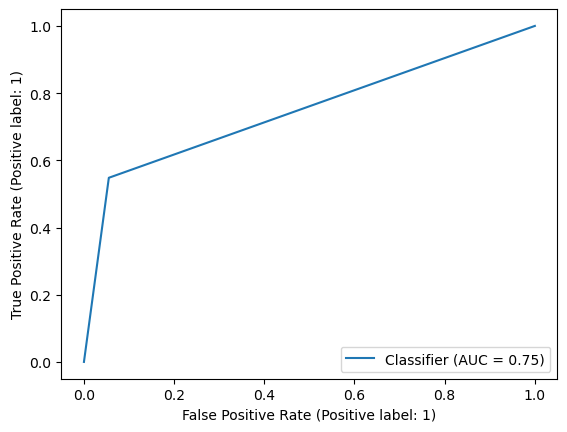

In [23]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, random_state=50)
model.fit(x_train, y_train)

predictions = model.predict(x_test)

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

display.plot()
plt.show()

display = RocCurveDisplay.from_predictions(
    y_test,
    predictions
)

print("Accuracy Score - Decision Tree: ", accuracy_score(y_test, predictions))
print("Precision Score - Decision Tree: ", precision_score(y_test, predictions))
print("Recall Score - Decision Tree: ", recall_score(y_test, predictions))

### Conclusions

•	In examining the dataset, it is evident that a substantial portion of individuals, approximately 50%, work between 30 to 40 hours per week. The majority, constituting 74%, are employed in the private sector, with the remaining workforce distributed across government sectors and self-employment. Moreover, more than 70% of the population holds at least a high school diploma.

•	Delving deeper into employment sectors, it is observed that within the 74% employed in the private sector, over 60% earn less than $50,000 annually. Notably, the trend indicates a higher proportion of married couples surpassing the $50,000 income threshold compared to other demographic groups.

•	Further dissecting the data, the proportion of individuals earning more than $50,000 is notably lower in the private sector compared to those who are self-employed. Moreover, there is a discernible increase in the number of individuals earning above $50,000 among those holding a master's degree.

•	We have considered Decision Tree and Random Forest models to fit our data. For the dataset we have chosen Random Forest seems to perform better than Decision Tree.

•	Exploring feature relationships, no significant correlation is found among input features. The model employed for analysis, a random forest classifier, demonstrated commendable performance. With an accuracy rate of 85.89%, the model exhibits robust predictive capabilities. Additionally, the precision score of 0.756 underscores the model's ability to accurately classify positive instances.

•	In conclusion, the random forest classifier effectively captured patterns within the dataset, yielding a solid 85.89% accuracy and demonstrating efficacy in predicting income categories. The findings underscore the nuanced interplay of factors influencing income levels, offering valuable insights for further analysis and decision-making.